In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


Download the dataset from https://www.kaggle.com/datasets/sapal6/waste-classification-data-v2/data and change the path in the code wherever necessary according to your system.

In [33]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [34]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import InputLayer, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D,MaxPooling2D
from keras.layers import BatchNormalization, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [35]:

import os

dataset_path = '/mnt/c/Users/ASUS/Downloads/archive/DATASET/TRAIN'

# Check if path exists
if os.path.exists(dataset_path):
    print("Path exists!")
    
    # List subdirectories (representing different classes)
    try:
        garbage_types = os.listdir(dataset_path)
        print(garbage_types)  # Should print the list of subfolders
    except FileNotFoundError:
        print(f"Directory '{dataset_path}' not found. Please verify the path.")
    except Exception as e:
        print(f"An error occurred: {e}")

else:
    print("Path not found!")


# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Determine if all images in the entore dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

Path exists!
['N', 'O', 'R']
N folder contains 2847 images.
O folder contains 12565 images.
R folder contains 7152 images.

The images in the dataset have different dimensions or color channels.


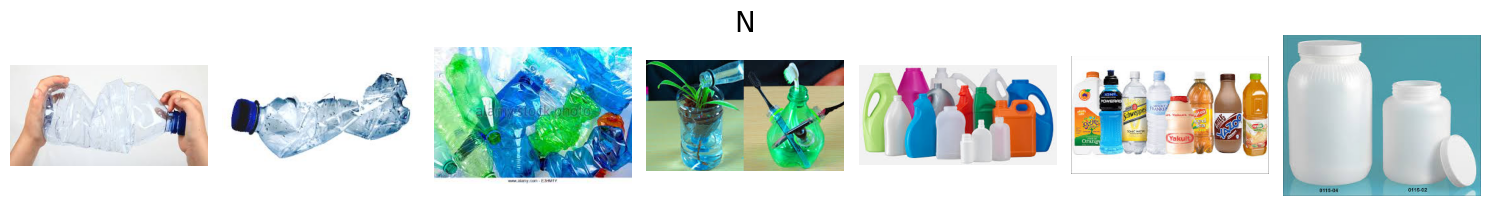

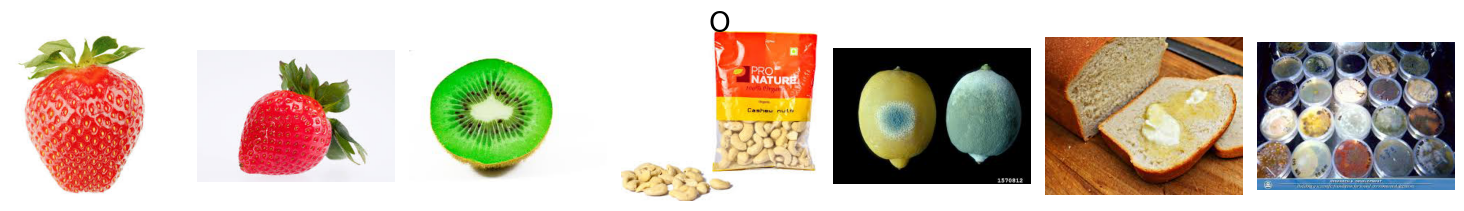

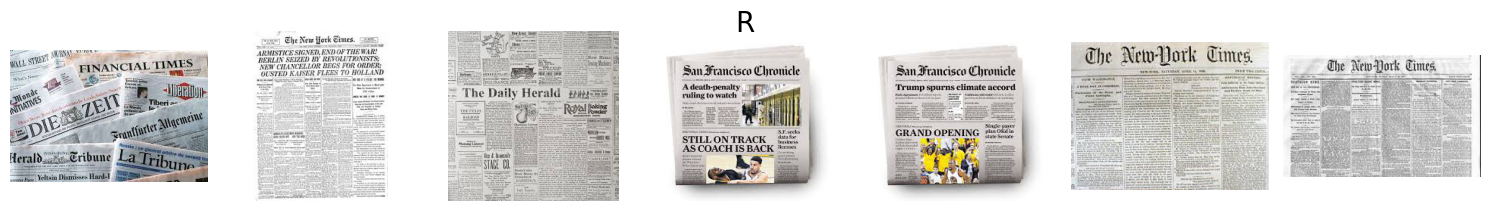

In [36]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:7]

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [37]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,/mnt/c/Users/ASUS/Downloads/archive/DATASET/TR...,N
1,/mnt/c/Users/ASUS/Downloads/archive/DATASET/TR...,N
2,/mnt/c/Users/ASUS/Downloads/archive/DATASET/TR...,N
3,/mnt/c/Users/ASUS/Downloads/archive/DATASET/TR...,N
4,/mnt/c/Users/ASUS/Downloads/archive/DATASET/TR...,N


In [38]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 18051
Number of images in the validation set: 4513


In [39]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [40]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,  
    seed=42
)


Found 18051 validated image filenames belonging to 3 classes.
Found 4513 validated image filenames belonging to 3 classes.


In [41]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, Lambda
from tensorflow.keras.models import Model

res = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224,224,3))


for i, layer in enumerate(res.layers):
    layer.trainable = i >= len(res.layers) - 40



In [42]:
# x = Flatten()(res.output)
# prediction = Dense(3,activation='softmax')(x)
from tensorflow.keras.regularizers import l2
x = GlobalAveragePooling2D()(res.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
prediction = Dense(3, activation='softmax')(x)

model_1 = Model(inputs=res.input, outputs=prediction)
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 58,856,963 (224.52 MB)

 Trainable params: 15,759,363 (60.12 MB)

 Non-trainable params: 43,097,600 (164.40 MB)

In [43]:
from keras.metrics import top_k_categorical_accuracy
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
callbacks = EarlyStopping(patience = 5, monitor='val_accuracy', mode='max')


model_1.compile(optimizer = Adam(learning_rate=0.00005),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [44]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

early_stop = EarlyStopping(patience=7, monitor='val_accuracy', mode='max', verbose=1)
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='/mnt/c/Users/ASUS/Desktop/best_modelrn2test.keras',        # or 'best_model.keras' for full model
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,                  
    mode='min',                              # 'min' because we want the lowest val_loss
    verbose=1
)



In [45]:

from sklearn.metrics import confusion_matrix


class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_true = self.validation_data
        # y_pred = self.model.predict(x_val, verbose=0)
        
        y_pred = self.model.predict(x_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_true, axis=1)

        cm = confusion_matrix(y_true_classes, y_pred_classes)
        print(f"\nConfusion Matrix after Epoch {epoch + 1}:")
        print(cm)





x_val, y_val = next(val_generator)


# Initialize the callback
cm_callback = ConfusionMatrixCallback((x_val, y_val))


In [46]:
import math


history = model_1.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / val_generator.batch_size),
    epochs=20,
    callbacks = [cm_callback,reduce_lr, early_stop,checkpoint] ,
    verbose=1
    
);


Epoch 1/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.6995 - loss: 1.1572
Confusion Matrix after Epoch 1:
[[ 3  0  4]
 [ 0 30  1]
 [ 0  1 25]]

Epoch 1: val_loss improved from inf to 0.68255, saving model to /mnt/c/Users/ASUS/Desktop/best_modelrn2test.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 269s 874ms/step - accuracy: 0.6998 - loss: 1.1565 - val_accuracy: 0.8976 - val_loss: 0.6826 - learning_rate: 5.0000e-05
Epoch 2/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.8826 - loss: 0.7176
Confusion Matrix after Epoch 2:
[[ 5  0  2]
 [ 0 30  1]
 [ 0  0 26]]

Epoch 2: val_loss improved from 0.68255 to 0.60021, saving model to /mnt/c/Users/ASUS/Desktop/best_modelrn2test.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 236s 831ms/step - accuracy: 0.8826 - loss: 0.7175 - val_accuracy: 0.9202 - val_loss: 0.6002 - learning_rate: 5.0000e-05
Epoch 3/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.9039 - loss: 0.6253
Confusion Matrix after Epoch 3:
[[ 5  0  2]
 [ 0 30  1]
 [ 1  0 25

In [47]:

import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    # Loss
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]

    epochs = range(1, len(history.history[acc_list[0]]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1], '.5f')) + ')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1], '.5f')) + ')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'r', label='Training loss (' + str(format(history.history[l][-1], '.5f')) + ')')
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'orange', label='Validation loss (' + str(format(history.history[l][-1], '.5f')) + ')')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


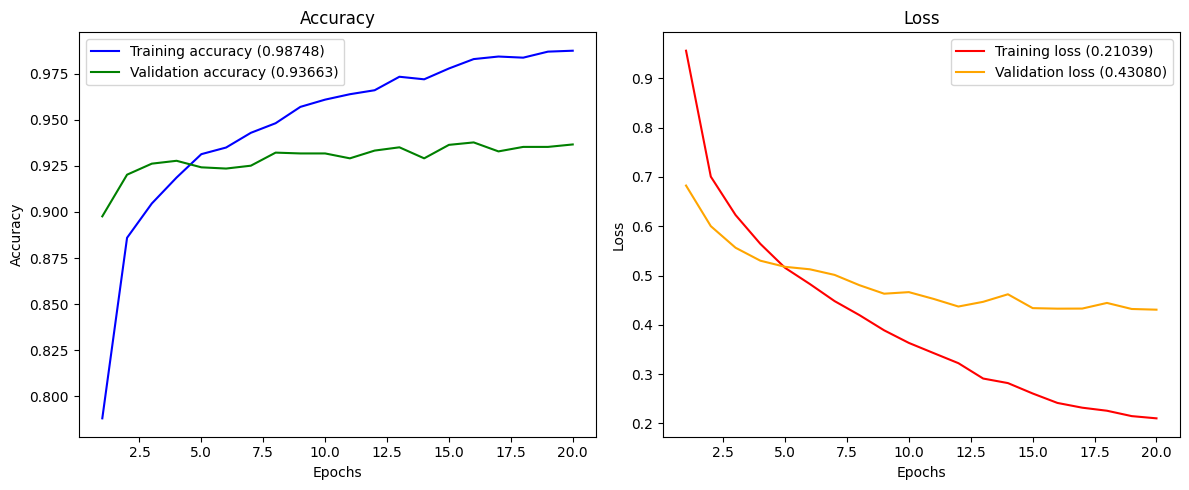

In [48]:
plot_history(history)